In [1]:

import numpy as np
from circ_stats import *
from numpy import *
from joblib import Parallel, delayed  
import multiprocessing
num_cores = multiprocessing.cpu_count()
from pickle import dump
from astropy.stats import circmean



/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Simulation parameters / code

In [2]:
sig=12 #6 # controls diffusion
N=1024 # number of colors / neurons
Nt = 10960 #number of trials to simulate
T=100 # number of time points to simulate per trial
n_subjects = 10 #200 #12

# parameters for serial biases simulated as a DoG 
a = 0.1 # serial biases strength: 0.1 for foster fig 1. 0.06 for experiment average fig4
w=0.02  # width of serial biases function
c = sqrt(2)/pow(np.e,-0.5)

def dog(x):
    return x*a*w*c*exp(-(w*x)**2)


def one_subject(Nt,s,interaction=True):

    def attractor(curr_cue,prev_cue):
        dist = circdist(curr_cue/N*2*pi,prev_cue/N*2*pi)
        bias = dog(degrees(dist))
        bias = sin(dist)*a
        return -bias

    print(s)
    prev_traces = np.zeros((Nt,T))
    cues =np.random.randint(0,Nt,Nt)
    curr_traces = np.zeros((Nt,T))

    # run previous trial - only interesting if we want to attract to previous trial end/report
    # the bump model predicts attraction to report/trial end is stronger than to stimulus/cue
    for i in range(Nt):
        prev_traces[i,0] = N/2
        prev_traces[i,1:] = prev_traces[i,0] + sig*np.cumsum(np.random.randint(-1,2,(T-1,)))

    #run current trial
    for i in range(Nt):
    
        curr_traces[i,0] =cues[i]
        for t in range(1,T):
            curr_traces[i,t] = curr_traces[i,t-1] + sig*np.random.randint(-1,2)

            ## chose one here!
            if interaction:
                curr_traces[i,t] += attractor(curr_traces[i,t],prev_traces[i,-1]) # attract to current "memory"
            else: 
                curr_traces[i,t] += attractor(cues[i],prev_traces[i,-1]) # attract to stimulus

    prev_traces = (prev_traces/N * 2*pi) % (2*pi)
    curr_traces = (curr_traces/N * 2*pi) % (2*pi)
    cues =cues/N * 2*pi

    return cues, prev_traces[:,-1], curr_traces[:,-1] 


# Analyses parameters / code

In [12]:

future=False
flip=False #True
type_ori = False #True # False
do_thirds = True
outlier_thr = 90


w2=pi/10
w1=pi/25

xxx_f=arange(0,pi,w1)
xxx2_f =xxx_f +w2/2 
xxx2_f = degrees(xxx2_f)

xxx_uf=arange(-pi,pi,w1)
xxx2_uf =xxx_uf +w2/2 
xxx2_uf = degrees(xxx2_uf)



if flip:
	xxx=xxx_f
else:
	xxx=xxx_uf



xxx2 =xxx +w2/2 #+w2/2
#xxx2 = degrees(xxx2)

def compute_serial(report,target,d,xxx,flip=None):
    n=0
    err=circdist(report,target)
    m_err=[]
    std_err=[]
    count=[]
    cis=[]
    uf_err = err.copy()
    if flip:
        err = sign(d)*err
        d=abs(d)
    points_idx=[]
    for i,t in enumerate(xxx):
        # wi=w[i]
        idx=(d>=t)&(d<=t+w2)
        m_err.append(circmean(err[idx]))
        std_err.append(circstd(err[idx]))
        count.append(sum(idx))
        points_idx.append(idx)
    return [array(err),d,array(m_err),array(std_err),count,points_idx,n,uf_err]




# Generate simulated data

In [4]:
# trials with interaction
subjects = Parallel(n_jobs=num_cores)(delayed(one_subject)(Nt,s) for s in range(n_subjects))
## 1 subject with all the trials trials
mega_subject = np.einsum("ijk -> jki",subjects).reshape(3,-1)

# trials without interaction
subjects_no_int = Parallel(n_jobs=num_cores)(delayed(one_subject)(Nt,s,interaction=False) for s in range(n_subjects))
## 1 subject with all the trials trials
mega_subject_no_int = np.einsum("ijk -> jki",subjects_no_int).reshape(3,-1)


/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  

0
2
1
3
4
6
7
5
8
9
0
1
2
3
4
5
6
7
8
9


## Analyse data

/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/astropy/stats/circstats.py:31: RuntimeWarning: invalid value encountered in double_scalars
  C = np.sum(weights * np.cos(p * (data - phi)), axis)/np.sum(weights, axis)
/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/astropy/stats/circstats.py:32: RuntimeWarning: invalid value encountered in double_scalars
  S = np.sum(weights * np.sin(p * (data - phi)), axis)/np.sum(weights, axis)


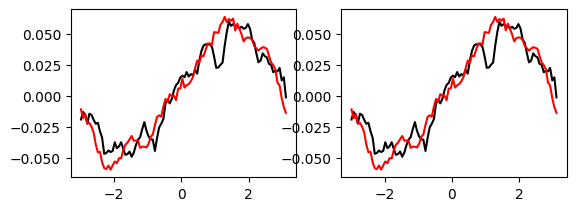

In [5]:
xxx = xxx2 

all_sbias_to_report = zeros([2,n_subjects,len(xxx2)])
all_sbias_to_stim = zeros([2,n_subjects,len(xxx2)])

for si,subject in enumerate(subjects):
    # simulated relative to memory
    cues = subject[0]
    prev_report = subject[1]
    curr_report = subject[2]
    prevstim_curr = circdist(radians(180),cues)
    prevreport_curr = circdist(prev_report,cues)
    # folded
    sbias_stim = compute_serial(curr_report,cues,prevstim_curr,xxx,flip)
    sbias_report = compute_serial(curr_report,cues,prevreport_curr,xxx,flip)
    all_sbias_to_report[0,si,:] = sbias_stim[2]
    all_sbias_to_report[1,si,:] = sbias_report[2]

    # simulated relative to stimuli
    subject = subjects[si]
    cues = subject[0]
    prev_report = subject[1]
    curr_report = subject[2]
    prevstim_curr = circdist(radians(180),cues)
    prevreport_curr = circdist(prev_report,cues)

    # folded
    sbias_stim = compute_serial(curr_report,cues,prevstim_curr,xxx,flip)
    sbias_report = compute_serial(curr_report,cues,prevreport_curr,xxx,flip)
    all_sbias_to_stim[0,si,:] = sbias_stim[2]
    all_sbias_to_stim[1,si,:] = sbias_report[2]


subplot(2,2,1)
plot(xxx,mean(all_sbias_to_report[0],0),"k",label="relative to stim")
plot(xxx,mean(all_sbias_to_report[1],0),"r",label="relative to report")
subplot(2,2,2)

plot(xxx,mean(all_sbias_to_stim[0],0),"k")
plot(xxx,mean(all_sbias_to_stim[1],0),"r")


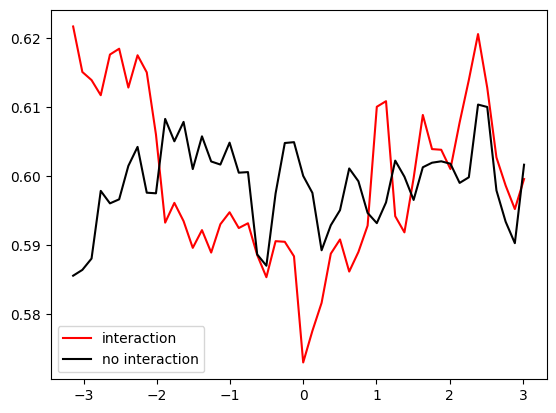

In [13]:
cues = mega_subject[0]
prev_report = mega_subject[1]
curr_report = mega_subject[2]
prevstim_curr = circdist(radians(180),cues)
prevreport_curr = circdist(prev_report,cues)
# folded
sbias_stim = compute_serial(curr_report,cues,prevstim_curr,xxx,flip)

# no interaction
cues = mega_subject_no_int[0]
prev_report = mega_subject_no_int[1]
curr_report = mega_subject_no_int[2]
prevstim_curr = circdist(radians(180),cues)
prevreport_curr = circdist(prev_report,cues)
# folded
sbias_stim_no_int = compute_serial(curr_report,cues,prevstim_curr,xxx,flip)


plt.plot(xxx,sbias_stim[3],'r',label="interaction")
plt.plot(xxx,sbias_stim_no_int[3],'k',label="no interaction")
plt.legend()